![title](7.1.png)

# 7.2 - Harmonic Oscillator Approximations

In [9]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook

A=np.array([[0, 1],[-1, 0]])

def eulerUpdate(y, h, x):
    return y + h*A.dot(y)

def rungeKuttaUpdate(y, h, x):
    k1 = h*A.dot(y)
    k2 = h*A.dot(y+k1/2.)
    k3 = h*A.dot(y+k2/2.)
    k4 = h*A.dot(y+k3)
    return y+k1/6.+k2/3.+k3/3.+k4/6.

def adaptiveUpdate(y, h, x, maxError, r = 2., N=3):
    error = float('inf')
    difThreshold = 0.1*maxError
    i=1
    
    while True:
        f1 = rungeKuttaUpdate(y, h, x)
        f2_1 = rungeKuttaUpdate(y, h/2, x)
        f2 = rungeKuttaUpdate(f2_1, h/2, x)
        error = (f1-f2)[0]
        if(abs(error)>maxError):
            f3 = rungeKuttaUpdate(rungeKuttaUpdate(y, h/4, x),h/4, x)
            error2 = (f2_1-f3)[0]
            gradient = (h/2)/abs(error-error2)
        else:
            if (maxError-abs(error))<difThreshold:
                return (f1, h, error)
            
            f2 = rungeKuttaUpdate(f1, h, x)
            f3 = rungeKuttaUpdate(y, 2*h, x)
            error2 = (f3-f2)[0]
           
            if i>=N:
                if abs(error2)>maxError:
                    return (f1, h, error)
                else:
                    return (f2, 2*h, error)
                
            gradient = (h)/abs(error2-error)
        h = h + min(max((abs(error)-maxError)*-gradient*r/i**0.5, -0.95*h),20*h)
        i+=1
        
def localError(y, h, x, f):
    f_1 = f(y,h,x)
    f_2 = f(f(y, h/2, x), h/2,x)
    val = f_1 - f_2
    return val[0]

def error(y, x):
    return y - np.array([np.cos(x), -np.sin(x)])

def calc(h, update, length=100*np.pi, initial = np.array([1,0])):    
    vals = np.ndarray((4, int(np.ceil(length/h))))
    vals[0, :] = np.arange(0, length, h)
    vals[1:3, 0] = initial
    vals[3] = 0
    x = 0
    for i in range(1,vals.shape[1]):
        y = vals[1:3, i-1]
        vals[1:3,i] = update(y, h, x)
        vals[3, i] = localError(y, h, x, update)
        x+=h
    return vals


def euler(h):
    return calc(h, eulerUpdate)

def rungeKutta(h):
    return calc(h, rungeKuttaUpdate)

def adaptiveRunge(maxError, initialH=0.001, length=100*np.pi):
    h = initialH
    vals = np.ndarray((5, 1))
    vals[0, 0] = 0
    vals[1:3, 0] = np.array([1, 0])
    vals[3] = 0
    x = 0
    i = 1
    while x < length:
        y = vals[1:3, i-1]
        val = np.ndarray(5)
        y, h, error = adaptiveUpdate(y, h, x, maxError)
        x+=h
        val[0] = x
        val[1:3] = y
        val[3] = error
        val[4] = h
        vals = np.append(vals, val.reshape((5,1)), axis=1)
        i+=1
    return vals  

def calcPlot(h):
    valsEuler = euler(h)
    valsRunge = rungeKutta(h)
    plt.figure(figsize=(12, 8))
    plt.title('Harmonic Oscillation Approximations with h=%f' % h)
    cosRange = np.arange(0, 100*np.pi, 0.01)
    cosVal = np.cos(cosRange)
    plt.plot(cosRange, cosVal, label='System')
    plt.plot(valsRunge[0,:], valsRunge[1,:], label='Runge-Kutta approximation')
    plt.plot(valsEuler[0,:], valsEuler[1,:], label='Euler approximation')
    plt.legend()
    plt.ylim((-2,2))
    plt.xlim((0,100*np.pi))
    plt.show()
    eulerError = error(valsEuler[1:3,-1], valsEuler[0,-1])
    rungeError = error(valsRunge[1:3,-1], valsRunge[0,-1])
    
    print(("Euler Error\n"
          "=====\n"
          "Mean abs local error:\t%f\n"
          "Final value error:\t%f\n"
          "Final slope error:\t%f\n"
          "\n"
          "Runge-Kutta Error\n"
          "=====\n"
          "Mean abs local error:\t%f\n"
          "Final value error:\t%f\n"
          "Final slope error:\t%f"
         ) % (np.mean(np.absolute(valsEuler[3,:])), eulerError[0], eulerError[1], np.mean(np.absolute(valsRunge[3,:])),rungeError[0],rungeError[1])
         )
    
    #plt.figure(figsize=(12, 8))
    #plt.title('Errors over Harmonic Oscillation with Adaptive Approximations')
    #plt.plot(valsRunge[0,:],valsRunge[3,:], label='local Error')
    #plt.legend()
    #plt.show()

def calcAdaptivePlot(maxError):
    vals = adaptiveRunge(maxError)
    plt.figure(figsize=(12, 8))
    plt.title('Harmonic Oscillation Adaptive Approximations with maxError=%f' % maxError)
    cosRange = np.arange(0, 100*np.pi, 0.01)
    cosVal = np.cos(cosRange)
    plt.plot(cosRange, cosVal, label='System')
    plt.plot(vals[0,:], vals[1,:], label='Adaptive Runge-Kutta')
    plt.legend()
    plt.ylim((-2,2))
    plt.xlim((0,100*np.pi))
    plt.show()
    
    rungeError = error(vals[1:3,-1], vals[0,-1])
    
    print(("Runge-Kutta Error\n"
          "=====\n"
          "Mean abs local error:\t%f\n"
          "Final value error:\t%f\n"
          "Final slope error:\t%f\n"
          "Mean h:\t%f\n"           
         ) % (np.mean(np.absolute(vals[3,:])),rungeError[0],rungeError[1], np.mean(vals[4,:]))
         )
    
    plt.figure(figsize=(12, 8))
    plt.title('h over Harmonic Oscillation with Adaptive Approximations')
    plt.plot(vals[0,:],vals[4,:], label='h')
    plt.ylim((0,1))
    plt.xlim((0,100*np.pi))
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(12, 8))
    plt.title('Local Error Magnitudes over Harmonic Oscillation with Adaptive Approximations')
    plt.plot((0, 100*np.pi), (maxError, maxError), 'red', label='maxError')
    plt.plot(vals[0,:],np.absolute(vals[3,:]), label='local Error')
    plt.ylim((0,2*maxError))
    plt.xlim((0,100*np.pi))
    plt.legend()
    plt.show()

<function legend at 0x7f0a10db3f50>


<IPython.core.display.Javascript object>


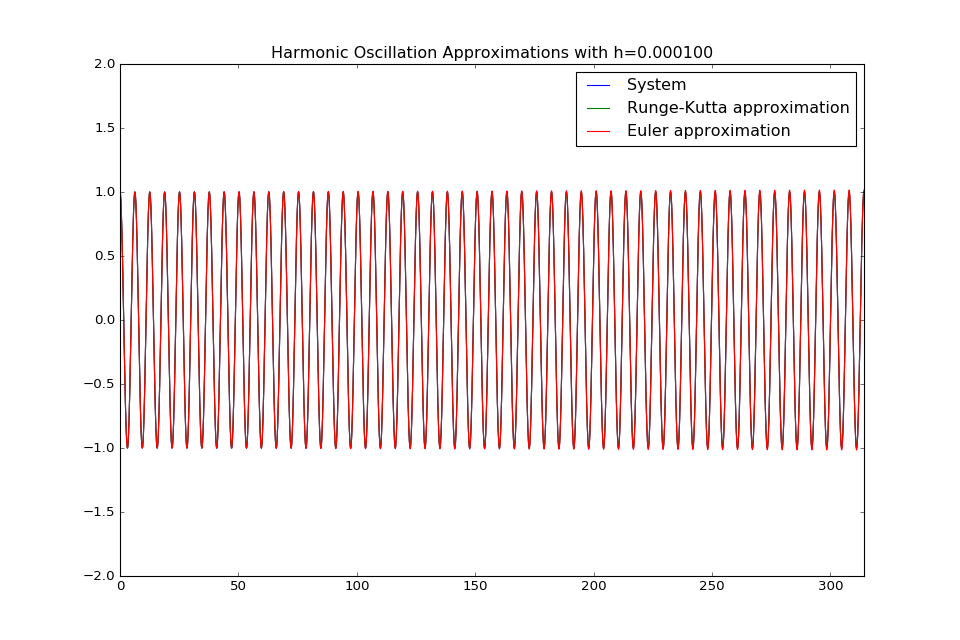

Euler Error
=====
Mean abs local error:	0.000000
Final value error:	0.015832
Final slope error:	0.000002

Runge-Kutta Error
=====
Mean abs local error:	0.000000
Final value error:	0.000000
Final slope error:	-0.000000


In [2]:
calcPlot(0.0001)



<IPython.core.display.Javascript object>


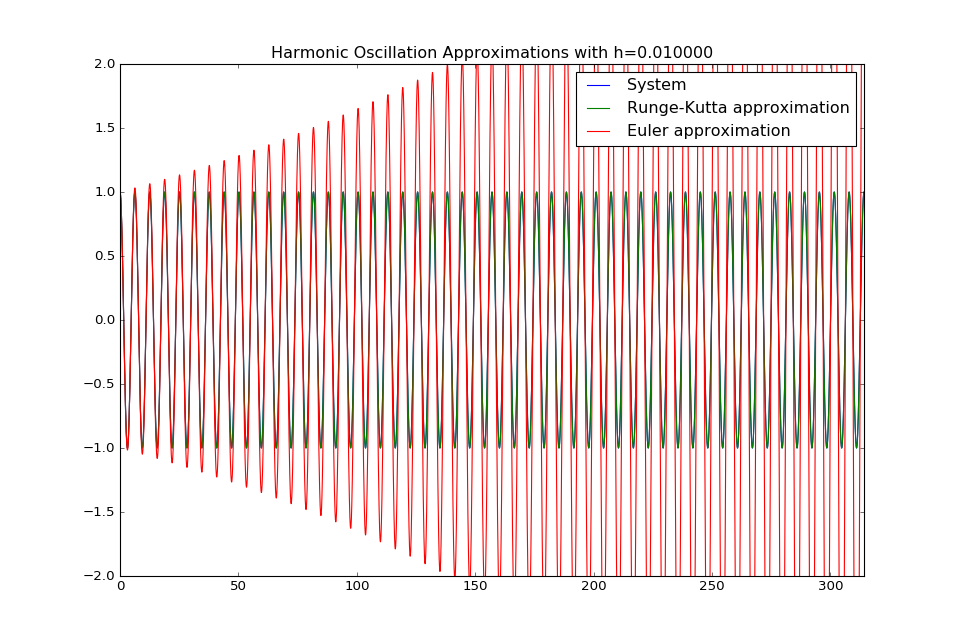

<function legend at 0x7f0a10db3f50>
Euler Error
=====
Mean abs local error:	0.000039
Final value error:	3.808983
Final slope error:	0.085658

Runge-Kutta Error
=====
Mean abs local error:	0.000000
Final value error:	-0.000000
Final slope error:	0.000000


In [7]:
calcPlot(0.01)

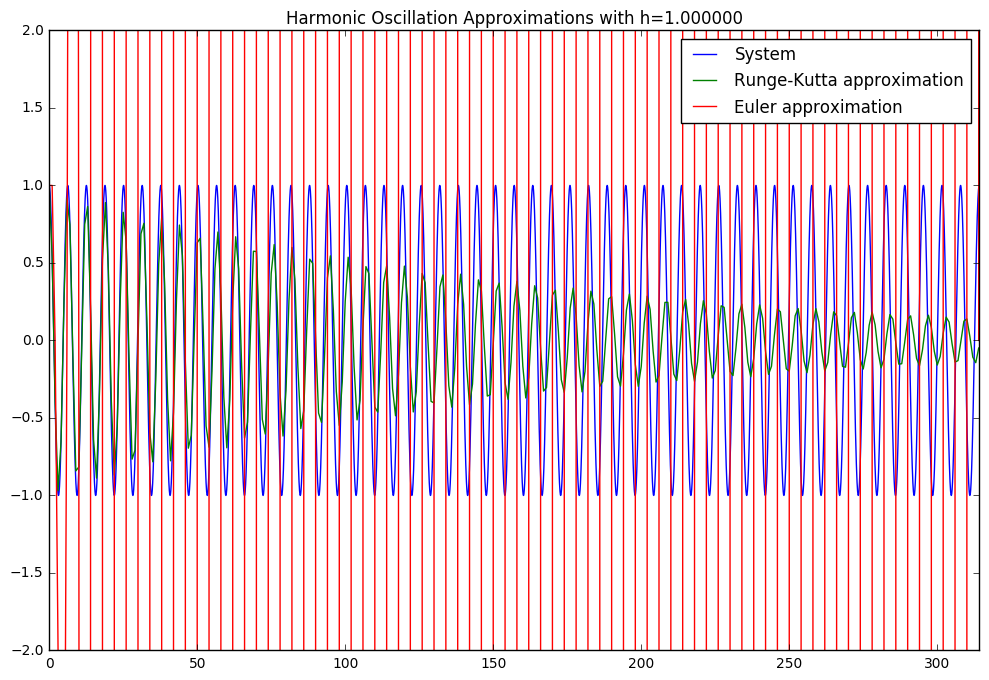

Euler Error
=====
Mean abs local error:	773281289593070220783632114572445969538875392.000000
Final value error:	-0.987344
Final slope error:	-182687704666362864775460604089535377456991567872.000000

Runge-Kutta Error
=====
Mean abs local error:	0.269047
Final value error:	-1.036285
Final slope error:	-0.020345


In [18]:
calcPlot(1)

# 7.3 - Adaptive Harmonic Oscillation Approximations

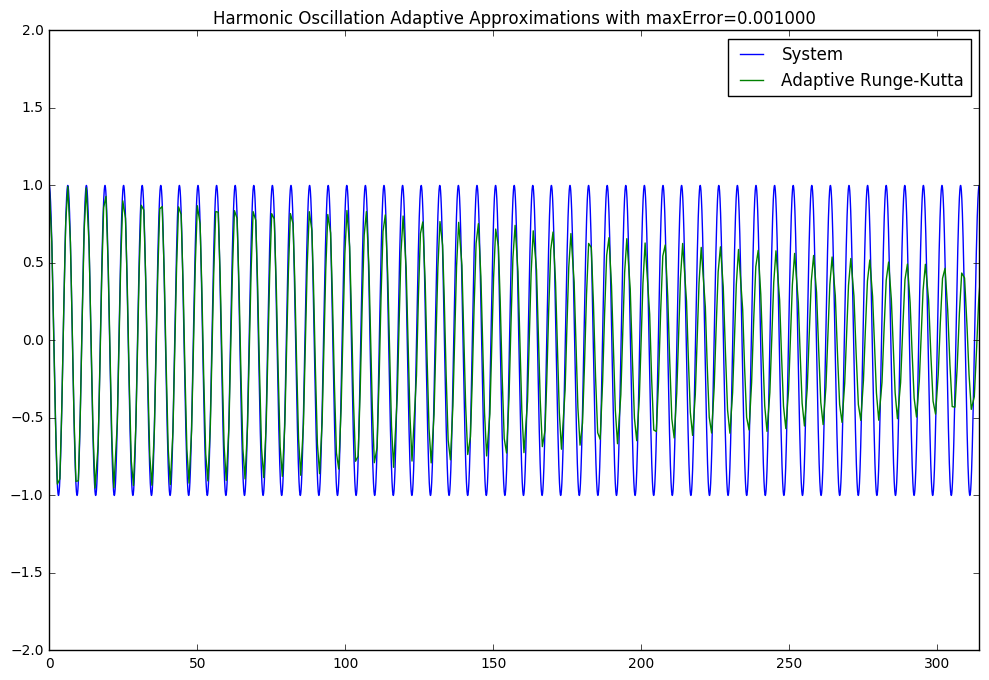

Runge-Kutta Error
=====
Mean abs local error:	0.000668
Final value error:	-0.356650
Final slope error:	0.671159
Mean h:	0.748293



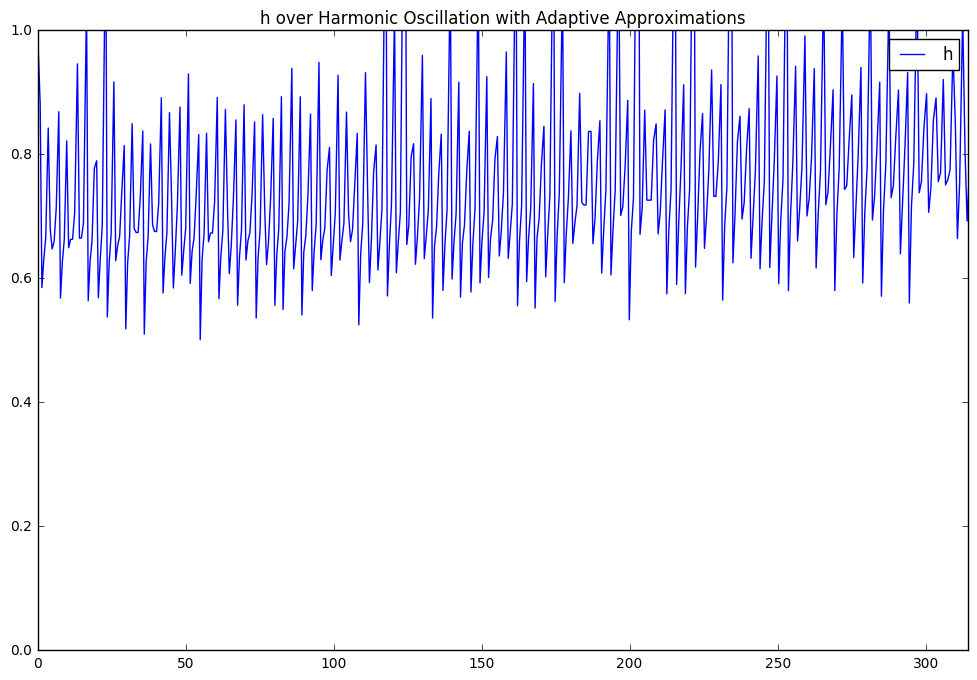

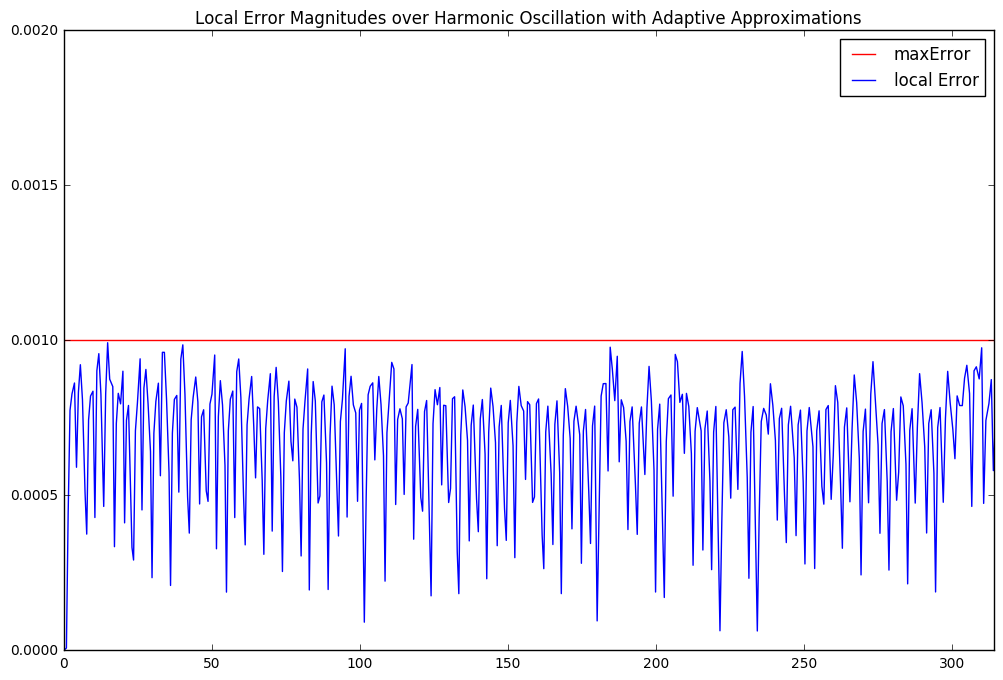

In [21]:
calcAdaptivePlot(0.001)

## Comparison to Non-Adaptive with h = mean(h) of Adaptive System

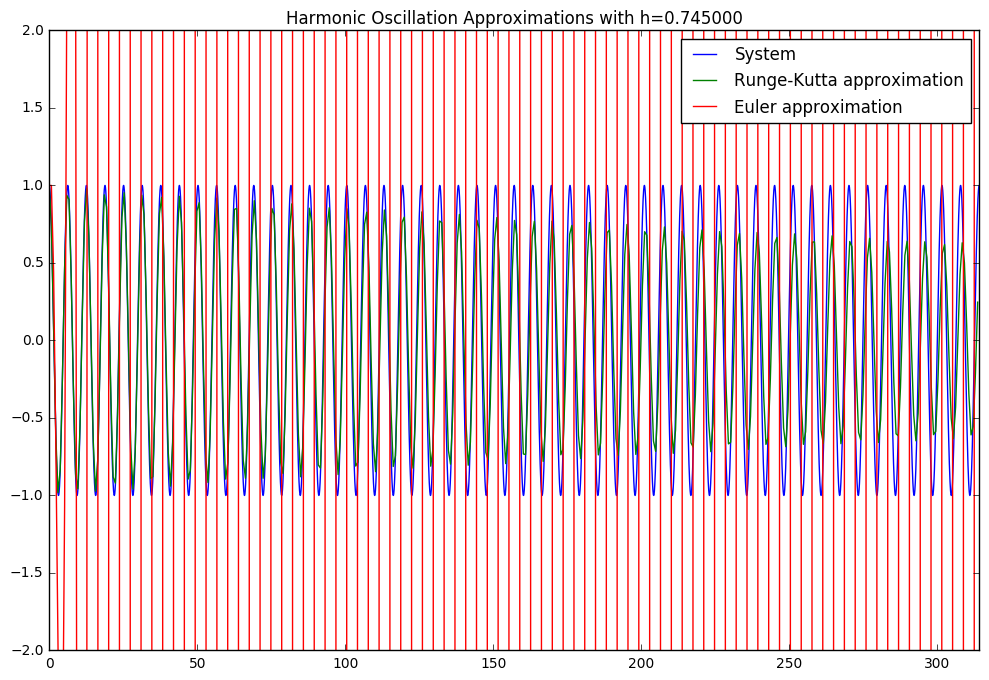

Euler Error
=====
Mean abs local error:	17446019482799028985269975079498809344.000000
Final value error:	18762798223333437274117966389790126374912.000000
Final slope error:	13209917695915979630558494501719360143360.000000

Runge-Kutta Error
=====
Mean abs local error:	0.000908
Final value error:	-0.623565
Final slope error:	0.085118


In [22]:
calcPlot(0.745)

# 7.4

In [288]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from ipywidgets import interact
%matplotlib notebook


class pendulum:   
    def __init__(self, l, w, A, h=0.002, initial=None, g=9.8):
        self.l=l
        self.g=g
        self.h=h
        self.w=w
        self.A=A
        self.x=0
        if initial==None:
            initial = np.array([np.pi/5, 0])
        self.y=initial
        
    def pendulumGradient(self, y, x):
        z_accel = self.w**2*self.A*np.sin(self.w*x)
        return np.array([y[1], (-self.g-z_accel)*np.sin(y[0])/self.l])

    def pendulumUpdate(self):
        self.x+=self.h
        k1 = self.h*self.pendulumGradient(self.y, self.x)
        k2 = self.h*self.pendulumGradient(self.y+k1/2., self.x+self.h/2.)
        k3 = self.h*self.pendulumGradient(self.y+k2/2.,self.x+self.h/2.)
        k4 = self.h*self.pendulumGradient(self.y+k3, self.x+self.h)
        self.y+=k1/6.+k2/3.+k3/3.+k4/6.
        return self.y

    def linePoints(self):
        return ([1,1+self.l*np.sin(self.y[0])], [1,1-self.l*np.cos(self.y[0])])

def animate(i):
    global p

    p.pendulumUpdate()
    lineX, lineY = p.linePoints()
    
    line.set_data(lineX, lineY)  # update the data
    line.set_data(lineX, lineY)
    dot.set_data(lineX[1], lineY[1])
    time_text.set_text(str(i*p.h))
    return line, dot

<IPython.core.display.Javascript object>


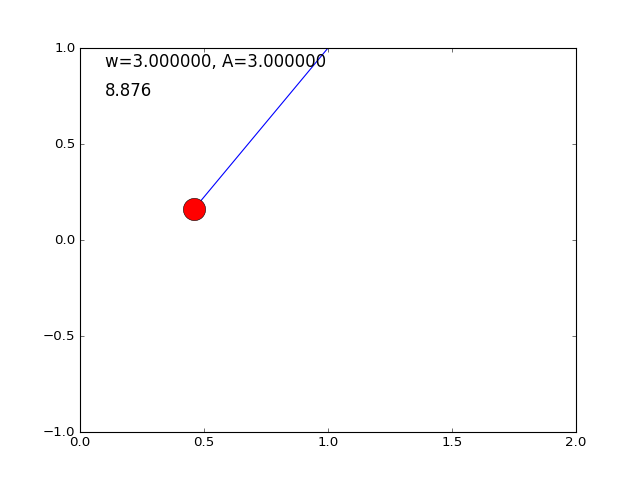

In [297]:
l=1
w=3
A=3
p = pendulum(1, 2, 3)

lineX, lineY = p.linePoints()

fig, ax = plt.subplots()

plt.ylim((-1,1))
plt.xlim((0,2))

plt.ion()

line, = ax.plot(lineX, lineY)
dot, = ax.plot(lineX[1], lineY[1], 'ro', markersize=20)
text = ax.text(.1, .9, 'w=%f, A=%f'%(w,A), fontsize=15)
time_text = ax.text(.1, .75, 'what', fontsize=15)

ani = animation.FuncAnimation(fig, animate, np.arange(1, 5000), interval=2)
plt.show()


#interact(run, A=(0,20,.1), w=(0,10,.1))   

#vals = calc(h, pendulumUpdate, initial=np.array([0,0]))

[ 0.62831853  0.        ]


<IPython.core.display.Javascript object>


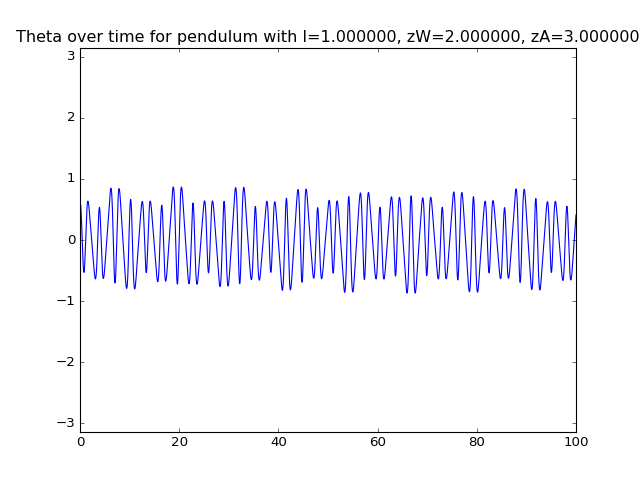

[0.62830693492171064, 0.628272072670785, 0.62821383224116378]


In [296]:
l, w, A = (1,2,3)

p2 = pendulum(l,w,A)
print p2.y
time = np.arange(0, 100, 0.002)
y = [p2.pendulumUpdate()[0] for t in time]

plt.figure()
plt.title("Theta over time for pendulum with l=%f, zW=%f, zA=%f" % (l,w,A))
plt.plot(time, y)
plt.ylim(-np.pi, np.pi)
print y[:3]